<!--COURSE_INFORMATION-->
*This notebook contains course material from [CBE 40455 Process Operations](http://jckantor.github.io/CBE40455/) by Jeffrey Kantor (jeff at nd.edu); the content is available [on GitHub](https://github.com/jckantor/CBE40455).*
*The text is released under the [CC-BY-NC-ND-4.0 license](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT).*


<!--NAVIGATION-->
< [Continuous Time Simulation in SimPy](02.07-Continuous-Time-Simulation-in-SimPy.ipynb) | [Contents](index.ipynb) | [Linear Optimization](03.00-Linear-Optimization.ipynb) >

<a href="https://colab.research.google.com/github/jckantor/CBE40455/blob/master/notebooks/02.08-Decentralized-Control-in-a-Supply-Chain.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


# Decentralized Control in a Supply Chain

In [0]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import control.matlab as control

## Model

#### Inventory Model

We model a single level in a heirarchical supply chain as an inventory, $Y(t)$, that is depleted by customer orders, $D(t)$, and replenished by supplier deliveries. Orders $U(t)$ are sent to the supplier at time $t$ for delivery at time $t+\tau$. The inventory is then given by

$$\frac{dY}{dt} = U(t-\tau) - D(t)$$

In this model, $U(t)$ and $D(t)$ have units of flowrate (i.e, quantity per unit time), whereas $Y$ has units of quantity.

We further assume the customer demand is characterized by a stationary but perhaps unknown mean value $\bar{D}$, and the inventory is controlled to a desired target level $\bar{R}$. 

#### Deviation Variables

We introduce deviation variables for the actual and target inventories

\begin{align*}
y(t) & = Y(t) - \bar{Y} \\
r(t) & = R(t) - \bar{R}
\end{align*}

and for the product flows

\begin{align*}
d(t) & = D(t) - \bar{D} \\
u(t) & = U(t) - \bar{U} \\
\end{align*}

normally we expect $\bar{Y} = \bar{R}$ and $\bar{U} = \bar{D}$. The deviation variables can represent positive or negative deviations from nominal steady-state conditions.

#### Inventory Model in Deviation Variables

In deviation variables, the deviation of the inventory level from a nominal value $\bar{Y}$ is given by

$$\frac{dy}{dt} = u(t-\tau) - d(t)$$

where $u$ and $d$ denote deviations from nominal conditions. After the Laplace transform (assuming zero initial conditions), the following transfer function model

$$y(s) = \frac{1}{s}e^{-\tau s}u(s) - \frac{1}{s}d(s)$$

is obtained for the response of the inventory to downstream customer demand and orders sent to the upstream suppliers.

## Ordering Policies

Here we consider the case of a single operator within a multi-level supply chain. The operator wishes to be part of a successful supply chain, but otherwise has only for the operator's own facility. We consider ordering policies for $u(s)$ that can be expressed as transfer functions operating on the available signals $y(s)$, $r(s)$, and $d(s)$. 

#### Feed-forward Ordering based on Customer Demand

A feed-forward policy would be to filter customer demand to determine orders,

$$u(s) = K_d(s) d(s)$$

where the single transfer function $K_d(s)$ is to be designed.


#### Ordering based on Feedback Control of Inventory

Feedback control is given by

$$u(s) = K_e(s)\left[r(s) - y(s)\right]$$

where $K_e(s)$ is the feedback policy determined by the 'error' $e(s) = r(s) - y(s)$, or difference, between the inventory target and actual inventory levels.

#### Ordering based on 2DOF Feedback Control of Inventory

The feedback policy can be further parameterized as

$$u(s) = K_r(s)r(s) - K_y(s)y(s)$$

where separate transfer functions are used for setpoint and process feedback.

#### A 3 DOF Feed-forward plus Feedback Ordering Policy

As a final consideration, we can write the ordering policy as 

$$u(s) = = K_r(s)r(s) - K_y(s)y(s) + K_d(s)d(s)$$

where the three degrees of freedom are the choices of $K_r(s)$, $K_y(s)$, and $K_d(s)$.

#### Closed-Loop Model

Solving for $u(s)$,

$$u(s) = \left[P(s) - K(s)G(s)]d(s) = $$

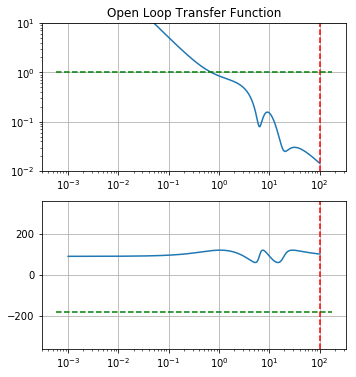

In [0]:
Kd = .5
[num,den] = control.pade(1,5)
D = Kd*control.tf(num,den)
I = control.tf([1],[1,0])

Hyd = I*(D-1)

def myBode(H):
    w = np.logspace(-3,2,401)
    mag,phase,omega = control.bode(H,w,deg=True,Plot=False);
    
    wc = np.interp(-180.0,np.flipud(phase),np.flipud(omega))
    gc = np.interp(wc,omega,mag)

    plt.figure(figsize=(12,6))
    plt.subplot(2,2,1)
    plt.loglog(omega,mag)
    plt.ylim(.01,10)
    plt.loglog([wc,wc],plt.ylim(),'r--')
    plt.loglog(plt.xlim(),[1,1],'g--')
    plt.grid()
    plt.title('Open Loop Transfer Function')
    
    plt.subplot(2,2,3)
    plt.semilogx(omega,phase)
    plt.ylim(-360,360)
    plt.semilogx(plt.xlim(),[-180,-180],'g--')
    plt.semilogx([wc,wc],plt.ylim(),'r--')
    plt.grid()

    
myBode(Hyd)

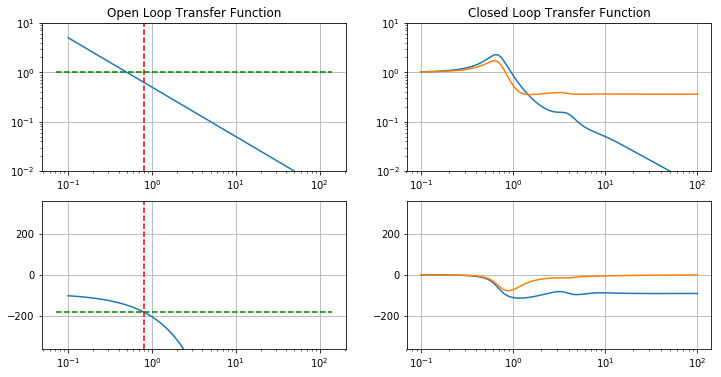

In [0]:
from ipywidgets import interact

w = np.logspace(-1,2,401)

def sim(torder=0, kp=.1, alpha = 0):

    num,den = control.pade(torder,5)
    p = control.tf(num,den)
    g = control.tf([1],[1,0])
    k = control.tf([kp],[1])
    mag,phase,omega = control.bode(g*p*k,w,deg=True,Hz=True, Plot=False);
    magc, phasec, omegac = control.bode(g*k/(1+g*p*k),w,deg=True,Hz=True, Plot=False);
    maga, phasea, omegaa = control.bode(alpha + (1-alpha)*g*k/(1+g*p*k),w,deg=True,Hz=True, Plot=False);
    
    wc = np.interp(-180.0,np.flipud(phase),np.flipud(omega))
    gc = np.interp(wc,omega,mag)

    
    plt.figure(figsize=(12,6))
    plt.subplot(2,2,1)
    plt.loglog(omega,mag)
    plt.ylim(.01,10)
    plt.loglog([wc,wc],plt.ylim(),'r--')
    plt.loglog(plt.xlim(),[1,1],'g--')
    plt.grid()
    plt.title('Open Loop Transfer Function')
    
    plt.subplot(2,2,3)
    plt.semilogx(omega,phase)
    plt.ylim(-360,360)
    plt.semilogx(plt.xlim(),[-180,-180],'g--')
    plt.semilogx([wc,wc],plt.ylim(),'r--')
    plt.grid()
    
    plt.subplot(2,2,2)
    plt.loglog(omegac,magc)
    plt.loglog(omegaa,maga)
    plt.ylim(.01,10)
    plt.grid()
    plt.title('Closed Loop Transfer Function')
    
    plt.subplot(2,2,4)
    plt.semilogx(omegac,phasec)
    plt.semilogx(omegaa,phasea)
    plt.ylim(-360,360)
    plt.grid()

interact(sim, torder=(0,8,.02), kp=(.1,5,.05), alpha = (-1,1,.01))

In [0]:
cont

<!--NAVIGATION-->
< [Continuous Time Simulation in SimPy](02.07-Continuous-Time-Simulation-in-SimPy.ipynb) | [Contents](index.ipynb) | [Linear Optimization](03.00-Linear-Optimization.ipynb) >

<a href="https://colab.research.google.com/github/jckantor/CBE40455/blob/master/notebooks/02.08-Decentralized-Control-in-a-Supply-Chain.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
